In [1]:
from IPython.display import Audio
def alarm():
      display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
from scipy.special import expit,logit
from datetime import date
import matplotlib as mpl
import time
from scipy import stats
mpl.style.use('classic')
from scipy.stats import gamma
pd.options.mode.chained_assignment = None

from zstat2 import ztest2 # it's a separate .py file (just include it in the same folder) download it from github repo
'''
please install the necessary libraries to fit gamma distribution
'''
# from mix_gamma_vi import mix_gamma_vi
# import tensorflow as tf
# import tensorflow_probability as tfp

'\nplease install the necessary libraries to fit gamma distribution\n'

Reading the file

In [3]:
start = time.time()
df1 = pd.read_pickle('../arm_bandit/kirk/kirk.pkl') # read the file from the workspace
nd = time.time()
print(nd-start)

16.529961109161377


In [4]:
'''
load the df, to reduce the df loading again and again from the disk
'''

df = df1[['trial','state', 'switch', 'stimTrial', 'rewarded','choice', 'correct','t1Rwd','t2Rwd','t3Rwd','animal_date','targOn','targAcq','rt']]
df['explore'] = np.where((df['state'] == 1), 1,0)

Need to fit the [gamma](https://pypi.org/project/mix-gamma-vi/)

(0.0, 0.4)

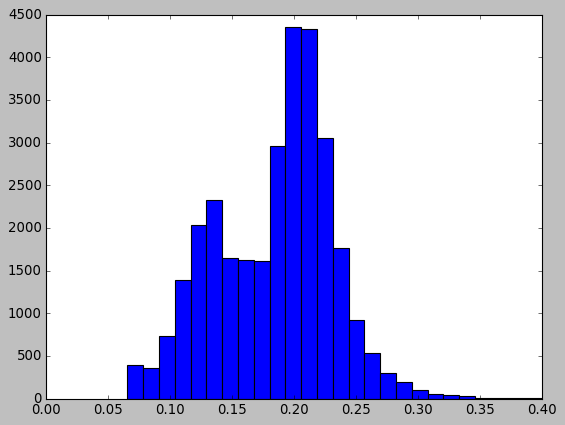

In [131]:
'''
First Look at the  response time of all sessions
'''
rt = df.rt.values
_ = plt.hist(rt, bins = 100)
plt.xlim(0,0.4)

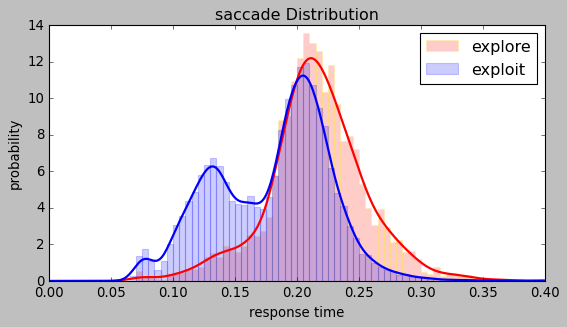

In [5]:
'''
Lets plot the histograms classifying between explore vs exploit trials
'''
df = df[df['correct'] == 1]


df_stim = df[(df['explore'] ==1)].rt
df_stim_not = df[(df['explore'] !=1)].rt
plt.figure(figsize=(8,4))
_ = plt.hist(df_stim,bins = np.arange(0,0.5,0.005), label='stimulated', alpha=0.2,color = 'r',  density = True,edgecolor='yellow')
 
# plotting second histogram
_ = plt.hist(df_stim_not,bins = np.arange(0,0.5,0.005), label='not-stimulated', alpha=0.2,color = 'b', density = True,edgecolor='blue')

plt.xlim(0,0.4)
plt.title('saccade Distribution')

density_s = stats.gaussian_kde(df_stim)
density_ns = stats.gaussian_kde(df_stim_not)

x = np.arange(0,0.4,0.001)
plt.legend(['explore', 'exploit'])
plt.plot(x,density_s(x),'r',x,density_ns(x),'b', linewidth = 2) # change the colors
# plt.legend(['explore', 'exploit','explore', 'exploit'])
plt.xlabel('response time')
plt.ylabel('probability')
plt.savefig('saccade_distribution.svg', format='svg', dpi=1200)

exploit, bimodal peak, expecting similar alpha but different weights

#### NEW PLAN :
* First cut off the the data below 100 ms
* Next fit the gamma distribution
* Draw the curve based on that as shown in the notebook (rishabh)
* Verify the gamma distribution and classify them into express based on the distribution



In [133]:
rt = df[df['rt'] >0.085].rt.values # remove the third population 

Text(0, 0.5, 'probability')

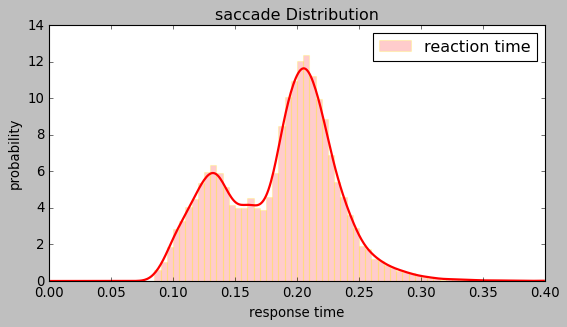

In [134]:
'''
Plot histogram of all the data
'''
plt.figure(figsize=(8,4))
_ = plt.hist(rt,bins = np.arange(0,0.5,0.005), label='stimulated', alpha=0.2,color = 'r',  density = True,edgecolor='yellow')
plt.title('saccade Distribution')
plt.xlim(0,0.4)
density_s = stats.gaussian_kde(rt)
x = np.arange(0,0.4,0.001)
plt.plot(x,density_s(x),'r', linewidth = 2) # change the colors
plt.legend(['reaction time'])
plt.xlabel('response time')
plt.ylabel('probability')

#### The trick to fit a skewes gamma is actually to move it near to origin. The further the gamma is away, the more it is like a gaussian. So to fit a skewed one like this one move it closer to origin - just subtract the min value. However, there will be a problem with a 0, so add some epsilon~0 to the distribution.

Text(0, 0.5, 'probability')

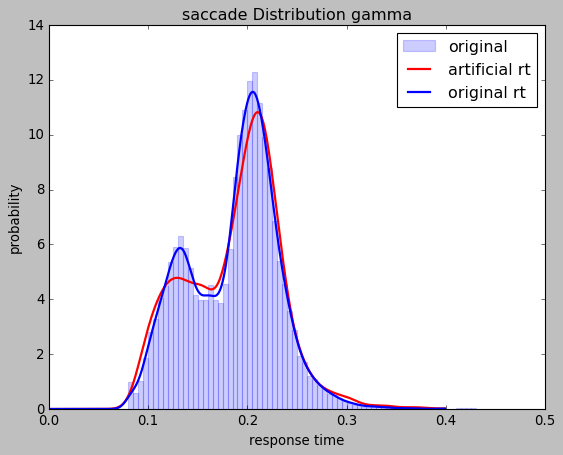

In [137]:
'''
This Code is to fit the mixture of gamma distribution on whole data. More like a test code
remove the third population
'''

rt1 = df[(df['rt'] > 0.08)].rt
# rt1 = df.rt.values
rt = rt1 - rt1.min()+0.001 # move it close to origin and add epsilon to fit bettwe for skew gamma and later shift it back to plot
'''
Fitting the gamma distribution
'''

fit_ore = mix_gamma_vi(rt, 2)
distribution = fit_ore.distribution()
dict1 = distribution.mean()
pi = dict1['pi'].numpy()

'''
keeping the parameters from the dictionary to a list
'''

mu = dict1['mu'].numpy()
alpha = dict1['alpha'].numpy()
beta = alpha/mu

'''
Generating samples from the parametric distribution to verify the fit
'''
N = 5000
mix_gamma = tfp.distributions.MixtureSameFamily(
    mixture_distribution=tfp.distributions.Categorical(probs=pi),
    components_distribution=tfp.distributions.Gamma(concentration=alpha, rate=beta))

simulated = mix_gamma.sample(N)
simulated = simulated.numpy()+rt1.min() - 0.0001 # move it back to original space with tolerance as well
simulated = simulated.flatten()
rt = rt1 # shifitng the response time back


# _ = plt.hist(simulated,bins = 100, label='stimulated', alpha=0.2,color = 'r',  density = True,edgecolor='yellow') # don't need artificial histogram just the line
_ = plt.hist(rt,bins = np.arange(0,0.5,0.005), label='not-stimulated', alpha=0.2,color = 'b', density = True,edgecolor='blue')

plt.title('saccade Distribution gamma')

'''
Kernel Estimation
'''
density_real = stats.gaussian_kde(rt)
density_s = stats.gaussian_kde(simulated)

x = np.arange(0,0.4,0.001)
plt.plot(x,density_s(x),'r', x,density_real(x),'b', linewidth = 2) # change the colors
plt.legend(['original','artificial rt', 'original rt'])
plt.xlabel('response time')
plt.ylabel('probability')
# plt.savefig('./gamma_fit.png')

In [6]:

'''
Runnning the same code but for all the sessions separately
Also saving the data in a dataframe of the probability distribution
'''
dates = df['animal_date'].unique()

alpha1 = [] # generating lists to hold parameters
beta1 = []
alpha2 = []
beta2 = []
pi1 = []
pi2 = []

prob = [] # 1  == express saccade ; - == not express saccade (larger mean ditribution)
raw_prob = [] # store the probability

df = df[df['correct'] == 1] #take correct trials

for date in dates:
    rt1 = df[(df['rt'] > 0.1 ) & (df['animal_date'] == date)].rt
    rt1 = rt1[~np.isnan(rt1)] 
    
    rt = rt1 - rt1.min() + 0.0001 # shifting the mean
    
    fit_ore = mix_gamma_vi(rt, 2) # fitting the distribution defined above
    distribution = fit_ore.distribution()
    dict1 = distribution.mean()
    pi = dict1['pi'].numpy()
    mu = dict1['mu'].numpy()
    
    alpha = dict1['alpha'].numpy()
    beta = alpha/mu
    # print(alpha)
    
    alpha1.append(alpha[0][0]) #store all the variables from dictionary into a list
    beta1.append(beta[0][0]) #store all the variables from dictionary into a list
    alpha2.append(alpha[0][1])#store all the variables from dictionary into a list
    beta2.append(beta[0][1])#store all the variables from dictionary into a list
    pi1.append(pi[0][0])#store all the variables from dictionary into a list
    pi2.append(pi[0][1])#store all the variables from dictionary into a list
    
    # got the parameters, generating samples to show in histogram, can also use the linspace 
    N = 5000
    '''
    Here defining a tensorflow distribution
    '''

    mix_gamma = tfp.distributions.MixtureSameFamily(
            mixture_distribution=tfp.distributions.Categorical(probs=pi),
            components_distribution=tfp.distributions.Gamma(concentration=alpha, rate=beta))
   
  
    logit = mix_gamma.posterior_marginal(rt).logits

    probability =(np.exp(logit)/(1+np.exp(logit))) # convert it to probability
    raw_prob.append(probability)
    logit = 1-np.argmax(probability, axis = 1) # pick the max and shift it to the notation of express vs non express
    prob.append(logit)
    '''
    PLOTTING FIGURES
    '''
    
    simulated = mix_gamma.sample(N)
    simulated = simulated.numpy()+rt1.min() - 0.0001 # plotting the original times
    simulated = simulated.flatten()
    plt.figure()
    
    rt = rt1 # getting old wo mean shifted response time

    # _ = plt.hist(simulated,bins = 100, label='stimulated', alpha=0.2,color = 'r',  density = True,edgecolor='yellow') # No need
    
    _ = plt.hist(rt,bins = np.arange(0,0.5,0.005), label='not-stimulated', alpha=0.2,color = 'b', density = True,edgecolor='blue')
    plt.title(f'saccade Distribution gamma {date}')
    density_real = stats.gaussian_kde(rt)
   
    x = np.arange(0,0.4,0.001)
    rv = gamma(alpha[0][0],loc = 0.1, scale = 1/beta[0][0])
    rv2 = gamma(alpha[0][1],loc = 0.1, scale = 1/beta[0][1])
    plt.plot(x, pi[0][0]*rv.pdf(x) +  pi[0][1]*rv2.pdf(x), 'r', lw=2, label='frozen pdf')
    
    # density_s = stats.gaussian_kde(simulated)
    plt.plot( x,density_real(x),'b', linewidth = 2) # change the colors
    plt.legend([' rt',' artificial rt' ,'original rt'])
    plt.xlabel('response time')
    plt.ylabel('probability')
    if date == '170929':
        plt.savefig('gamma_fit.svg')


NameError: name 'mix_gamma_vi' is not defined

In [106]:
mix_gamma.components_distribution.mean() #mean of each distribution

<tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[0.0841822 , 0.11796654]])>

In [142]:
'''
Test case to plot mixture using scipy
It works but didn't need to use it here.
'''

# from scipy.stats import gamma

# import matplotlib.pyplot as plt
# a = 1.359293
# b = 1/16.919752
# a2  = 39.491901
# b2 = 1/340.806167

# fig, ax = plt.subplots(1, 1)
# x = np.linspace(0,4, 1000)/10
# rv = gamma(a,loc = 0.1, scale = b)
# rv2 = gamma(a2,loc = 0.1, scale = b2)
# ax.plot(x, 0.3007*rv.pdf(x) +  0.699*rv2.pdf(x), 'k-', lw=2, label='frozen pdf')

'\nTest case to plot mixture using scipy\n'

In [143]:
'''
storing the probability distribution parameters as dataframe
'''

import pandas as pd
di = {'alpha1' : np.array(alpha1), 'beta1' : np.array(beta1), 'alpha2' : np.array(alpha2), 'beta2' : np.array(beta2), 'dates' : dates , 'pi1' :pi1, 'pi2' :pi2}
pdf = pd.DataFrame(di)
# pdf

In [144]:
 '''
 This code is for fitting a (GMM) Gaussian mixture model, [the results were not as good as the gamma]
 Feel freee to mess with it.
 '''

# from sklearn.mixture import GaussianMixture

# # fitting
# df = df[df['correct'] == 1]
# for date in dates:
#     rt = df[(df['rt'] > 0.08 ) & (df['animal_date'] == date)].rt.values
#     rt = rt[~np.isnan(rt)]
    
#     gmm = GaussianMixture(n_components=2, random_state=42) # define the model with components
#     fit = gmm.fit(rt.reshape(-1,1)) 
#     # distribution = fit_ore.distribution()

#     N = 5000

#     simulated = fit.sample(N)
#     simulated = simulated[0].flatten()
#     plt.figure()

#     # _ = plt.hist(simulated,bins = 100, label='stimulated', alpha=0.2,color = 'r',  density = True,edgecolor='yellow')
#     _ = plt.hist(rt,bins = np.arange(0,0.5,0.005), label='not-stimulated', alpha=0.2,color = 'b', density = True,edgecolor='blue')
#     plt.title(f'saccade Distribution GMM {date}')
#     density_real = stats.gaussian_kde(rt)

#     density_s = stats.gaussian_kde(simulated)
#     x = np.arange(0,0.4,0.001)
#     plt.plot(x,density_s(x),'r', x,density_real(x),'b', linewidth = 2) # change the colors
#     plt.legend([' rt',' artificial rt' ,'original rt'])
#     plt.xlabel('response time')
#     plt.ylabel('probability')
#     # plt.savefig(f'./gmm_fit_{date}.png')

'\nThis code is for fitting a GMM Gaussian mixture model\n'

we have the express saccaade gamma distribution, Now let's draw the plot.

In [145]:
'''
adding the express saccade to the df for aliging the trials and furthere analysis
'''

df = df1[['trial','state', 'switch', 'stimTrial', 'rewarded','choice', 'correct','t1Rwd','t2Rwd','t3Rwd','animal_date','targOn','targAcq','rt']]
df = df[df['rt'] >0.1]
df = df[df['correct'] == 1]
prob = np.concatenate(prob).ravel()
raw_prob = np.concatenate(raw_prob).ravel()
df['probability'] = prob
df['explore'] = np.where((df['state'] == 1), 1,0)


In [3]:
'''
saving the file (express saccades) as numpy  to send

'''
# prob.astype('int16').tofile('./exp_probability_kirk')
prob_r = np.fromfile('./exp_probability_kirk', dtype='int16')
len(prob_r) # printing the number of trials

29532

In [23]:
'''
Feel free to ignore this, it was just verifying the maths done above
'''

# pro = np.rint(raw_prob)
#raw_prob[-1][-10:-1], prob[-10:-1], logi[-1][-10:-1], len(raw_prob), rt.iloc[-10:-1],mix_gamma.components_distribution.prob(0.15)


'\nFeel free to ignore this, it was just verifying the maths done above\n'


### P(express | Expploit) = Number of exppress saccades during exploit state / Number of total trials during exploit state


In [61]:
'''
Here getting the probability of express saccades by using mean over explore and exploit trials
P(express | Expploit) = Number of exppress saccades during exploit state / Number of total trials during exploit state
'''

# df['probability']=df.groupby('animal_date').transform(lambda x: x / x.max()).probability # this was different way of doing it
prob_r = np.fromfile('./exp_probability_kirk', dtype='int16')
df = df[df['correct'] == 1]
df = df[df['rt'] >0.1]
df['probability'] = prob_r
df_t = df.groupby(['animal_date','explore']).mean().reset_index()
df_t['counting']=df.groupby(['animal_date','explore']).count().reset_index().trial.values # keeping count of trial for each state to test ztest later


#### Do the Z test for  2 populations here

In [60]:
'''
We will use groupby function and then apply ztest to each group
You can read the documentation
but it requires the number of trials in each group and the mean of each group in a list format
and for other group as well in list format

Here the two groups are exploit and explore, We will use the count of trials in each group and the mean of probability in each group
to see if the probability of express saccades is significantly different between the two groups.

so input will be like this

result = ztest2([mean1, count1], [mean2, count2]) # result is also in list format, where first value holds the answer.
output will be a list containing three items

'''
test_df = pd.DataFrame()
test_df['animal_date1'] = df_t[df_t['explore'] == 0].animal_date.values
test_df['probability'] = df_t[df_t['explore'] == 0].probability.values # probability== OIT
test_df['count'] = df_t[df_t['explore'] == 0].counting.values
test_df['probability2'] = df_t[df_t['explore'] == 1].probability.values # probability2 == OIT
test_df['count2'] = df_t[df_t['explore'] == 1].counting.values
test_df['animal_date2'] = df_t[df_t['explore'] == 1].animal_date.values

print(sum(test_df['animal_date1'] == test_df['animal_date2'])) # checking if the animal dates are same for both groups

for row in test_df.itertuples():
    result = ztest2([row.probability, row.count], [row.probability2, row.count2])
    test_df.loc[row.Index, 'ztest'] = result[0]
    test_df.loc[row.Index, 'pvalue'] = result[1]


20


In [63]:
exploit_sig = test_df[test_df['ztest'] == 1 ].probability.values # P(express| OIT)
explore_sig = test_df[test_df['ztest'] == 1].probability2.values # P(Express | ORE)
exploit = test_df[test_df['ztest'] == 0 ].probability.values # P(express| OIT)
explore = test_df[test_df['ztest'] == 0].probability2.values # P(Express | ORE)

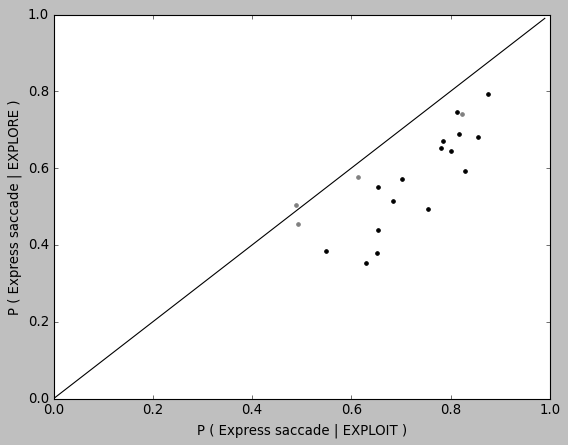

In [65]:
'''
Create the plot for the different probabilities
exploit_sig and explore_sig are the probability of express saccades for the trials that are significantly different and we plot them in dark grey
exploit and explore are the probability of express saccades for the trials that are not significantly different and we plot them in light grey
'''

plt.scatter(explore_sig,exploit_sig, color = 'black', s = 10)
plt.scatter(explore,exploit, color = 'grey', s = 10)
plt.xlim(0,1)
plt.ylim(0,1)
x = np.arange(0,1,0.01)

plt.xlabel('P ( Express saccade | EXPLOIT )')
plt.ylabel('P ( Express saccade | EXPLORE )')
plt.plot(x,x,color = 'black')
plt.savefig('express_saccades.svg',format = 'svg' )

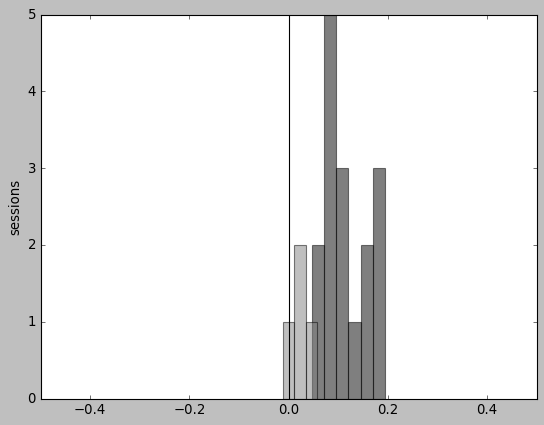

In [74]:
'''
create the histogram plot by roatting the plane (so it aligns with y=x above and look super cool)
Again as above, we plot the significantly different trials in dark grey and the non-significant trials in light grey
Also keeps the bins equally spaces so that the histogram is evenly ditributed and looks good

'''

x_rotate_sig = (explore_sig+exploit_sig)/np.sqrt(2)
y_rotate_sig = (explore_sig - exploit_sig)/np.sqrt(2)
x_rotate = (explore+exploit)/np.sqrt(2)
y_rotate = (explore - exploit)/np.sqrt(2)
_ = plt.hist(y_rotate_sig, bins = 6, color = 'black', alpha = 0.5)
_ = plt.hist(y_rotate, bins = 3, color = 'grey', alpha = 0.3)
plt.xlim(-0.5,0.5)
plt.vlines(x = 0,ymin=0,ymax=5, colors = 'black' )
plt.ylim(0,5)
plt.ylabel('sessions')
plt.savefig('express_saccades_hist.svg',format = 'svg' )

## The following work is just trying different monkeys, which did not work as they did not ahve a separate population of express saccades

# The End of the Notebook 📝👋🏼
Thank you for taking the time to read through this notebook. I hope you found it informative and useful for your work or personal projects. 🙌🏼🤓

If you have any questions or feedback, please don't hesitate to reach out. I amn alwways looking for ways to improve my work and appreciate any input you may have. 💬👀

🤖📊🧠



In [ ]:
monkey_session = os.listdir('../pleaseworkbyMARIEM/bo/')
monkey_session_o = os.listdir('../pleaseworkbyMARIEM/o/')


In [ ]:
df = pd.read_pickle('../pleaseworkbyMARIEM/bo/boMIB3031215b3_dat.mat.pkl')

In [ ]:
'''
i = 1
for session in monkey_session:
    df = pd.read_pickle(f'../pleaseworkbyMARIEM/bo/{session}')
    df = df[df['correct'] == 1]
    plt.figure()
    df['explore'] = np.where((df['states'] == 1), 1,0)
    df_stim = df[(df['explore'] ==1)].rt
    df_stim_not = df[(df['explore'] !=1)].rt
    plt.figure(figsize=(8,4))
    _ = plt.hist(df_stim,bins = np.arange(0,0.5,0.005), label='stimulated', alpha=0.2,color = 'r',  density = True,edgecolor='yellow')

    # plotting second histogram
    _ = plt.hist(df_stim_not,bins = np.arange(0,0.5,0.005), label='not-stimulated', alpha=0.2,color = 'b', density = True,edgecolor='blue')

    plt.xlim(0,0.4)
    plt.title(f'saccade Distribution BO session-{i}')

    # density_s = stats.gaussian_kde(df_stim)
    # density_ns = stats.gaussian_kde(df_stim_not)

    x = np.arange(0,0.4,0.001)
    # plt.plot(x,density_s(x),'r',x,density_ns(x),'b', linewidth = 2) # change the colors
    plt.legend(['explore', 'exploit'])#,'explore', 'exploit'])
    plt.xlabel('response time')
    plt.ylabel('probability')
    # plt.savefig(f'../express_saccades/timon_bo_o/BO session-{i}.png')
    i+=1
    '''

In [ ]:
'''
i = 1
for session in monkey_session_o:
    df = pd.read_pickle(f'../pleaseworkbyMARIEM/o/{session}')
    df = df[df['correct'] == 1]
    plt.figure()
    df['explore'] = np.where((df['states'] == 1), 1,0)
    df_stim = df[(df['explore'] ==1)].rt
    df_stim_not = df[(df['explore'] !=1)].rt
    plt.figure(figsize=(8,4))
    _ = plt.hist(df_stim,bins = np.arange(0,0.5,0.005), label='stimulated', alpha=0.2,color = 'r',  density = True,edgecolor='yellow')

    # plotting second histogram
    _ = plt.hist(df_stim_not,bins = np.arange(0,0.5,0.005), label='not-stimulated', alpha=0.2,color = 'b', density = True,edgecolor='blue')

    plt.xlim(0,0.4)
    plt.title(f'saccade Distribution O session-{i}')

    # density_s = stats.gaussian_kde(df_stim)
    # density_ns = stats.gaussian_kde(df_stim_not)

    x = np.arange(0,0.4,0.001)
    # plt.plot(x,density_s(x),'r',x,density_ns(x),'b', linewidth = 2) # change the colors
    plt.legend(['explore', 'exploit'])#,'explore', 'exploit'])
    plt.xlabel('response time 0')
    plt.ylabel('probability')
    # plt.savefig(f'../express_saccades/timon_bo_o/O session-{i}.png')
    i+=1
    '''

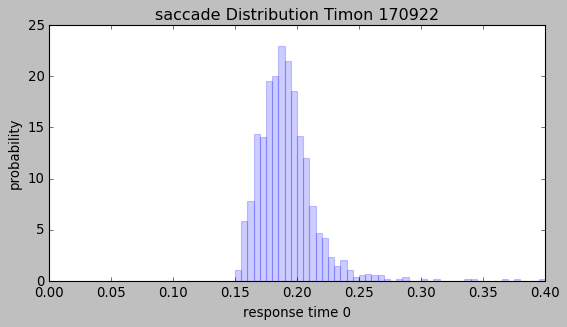

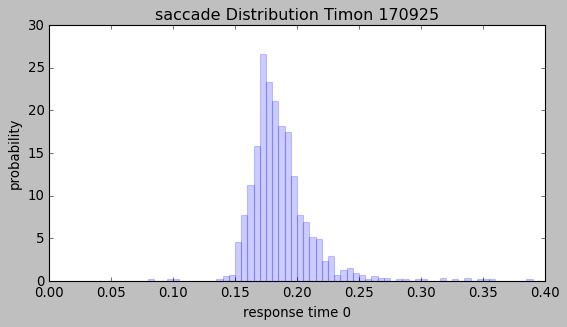

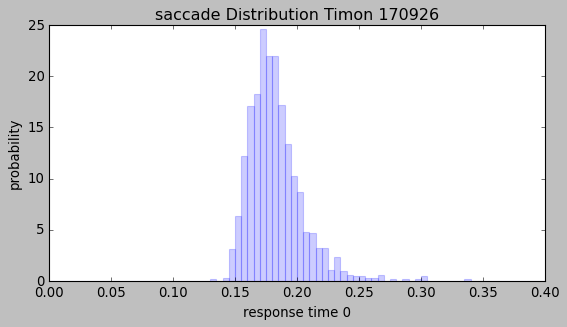

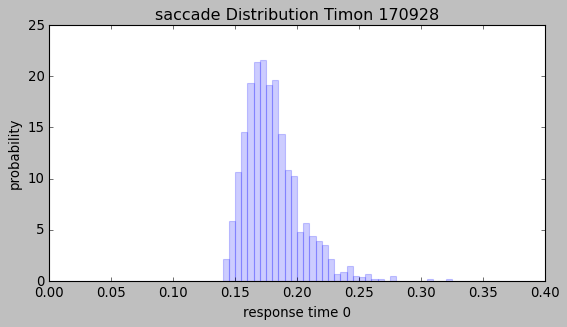

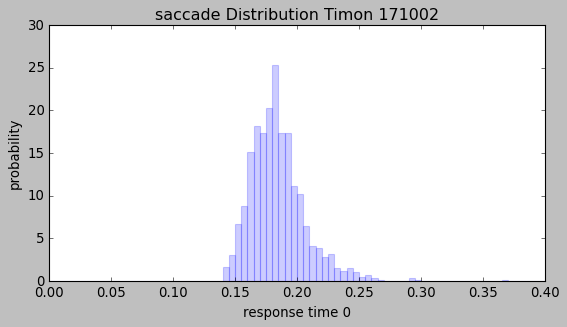

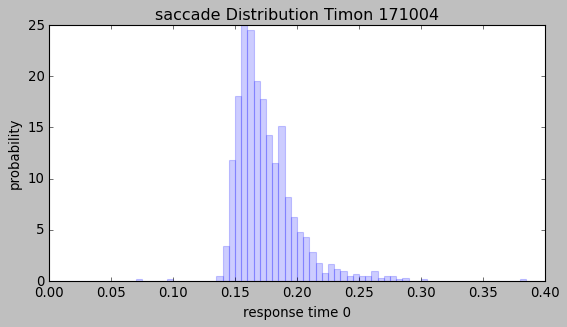

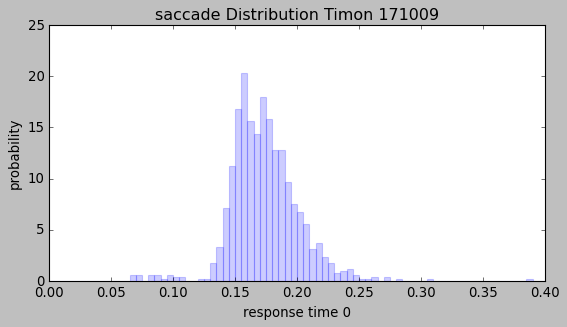

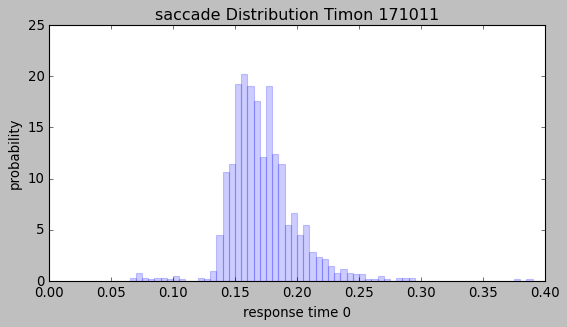

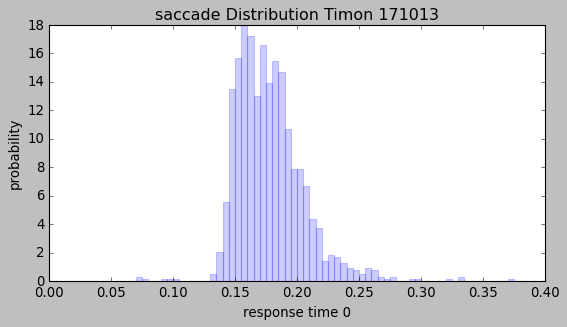

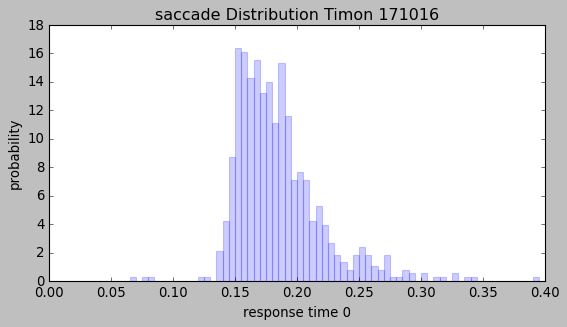

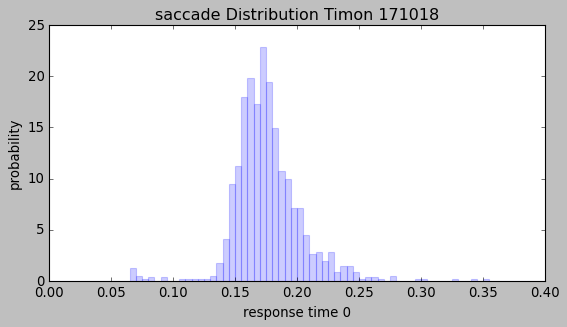

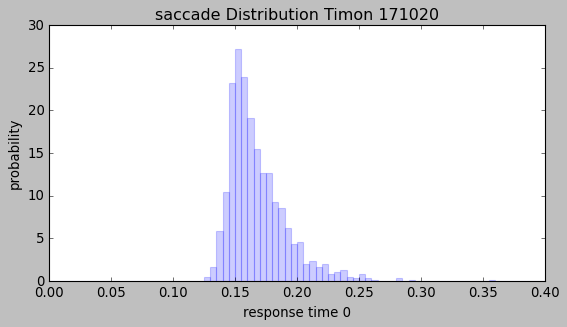

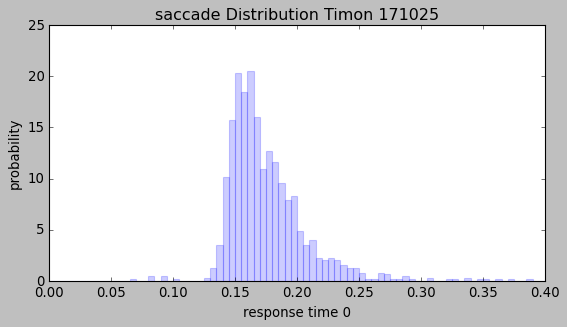

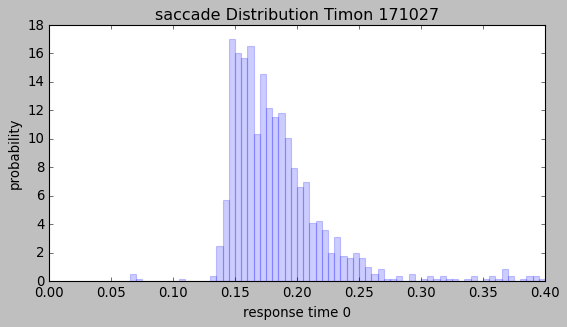

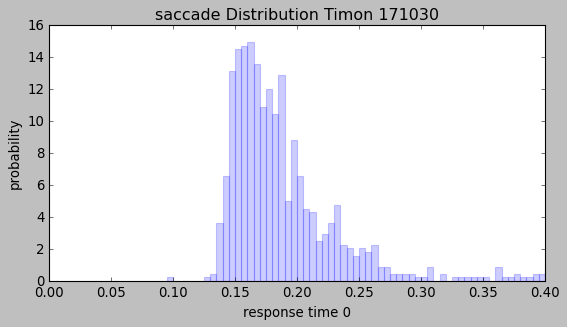

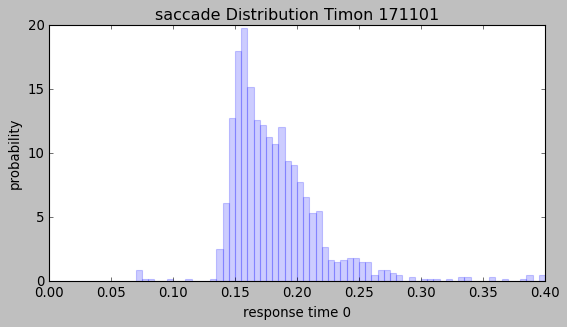

In [133]:
'''df1 = pd.read_pickle('../Timon.pkl')
df = df1[['trial','state', 'switch', 'stimTrial', 'rewarded','choice', 'correct','t1Rwd','t2Rwd','t3Rwd','animal_date','targOn','targAcq','rt']]
dates = df['animal_date'].unique()
'''
Runnning the same code but for all the sessions separately
Also saving the data in a dataframe of the probability distribution
'''

df = df[df['correct'] == 1]
for date in dates:
    df1 = df[(df['rt'] > 0.03 ) & (df['animal_date'] == date)]

    df1['explore'] = np.where((df1['state'] == 1), 1,0)
    df_stim = df1[(df1['explore'] ==1)].rt
    df_stim_not = df1[(df1['explore'] !=1)].rt
    plt.figure(figsize=(8,4))
    # _ = plt.hist(df_stim,bins = np.arange(0,0.5,0.005), label='stimulated', alpha=0.2,color = 'r',  density = True,edgecolor='yellow')

    # plotting second histogram
    _ = plt.hist(df1.rt.values,bins = np.arange(0,0.5,0.005), label='not-stimulated', alpha=0.2,color = 'b', density = True,edgecolor='blue')

    plt.xlim(0,0.4)
    plt.title(f'saccade Distribution Timon {date}')

    # density_s = stats.gaussian_kde(df_stim)
    # density_ns = stats.gaussian_kde(df_stim_not)

    x = np.arange(0,0.4,0.001)
    # plt.plot(x,density_s(x),'r',x,density_ns(x),'b', linewidth = 2) # change the colors
    # plt.legend(['explore', 'exploit'])#,'explore', 'exploit'])
    plt.xlabel('response time 0')
    plt.ylabel('probability')
    # plt.savefig(f'../express_saccades/timon_bo_o/Timon {date}.png')
'''

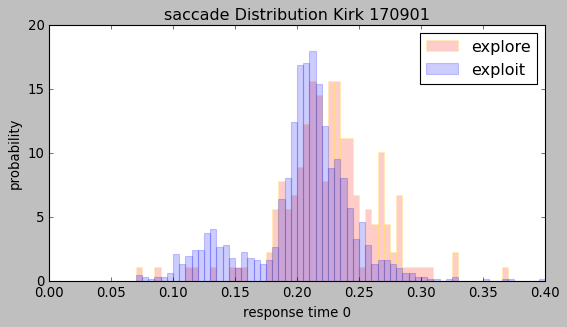

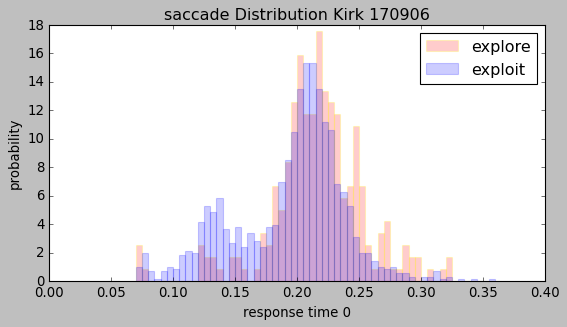

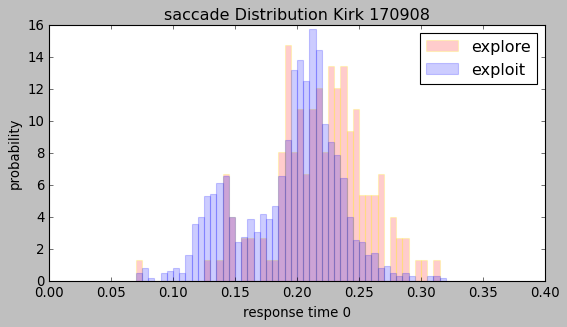

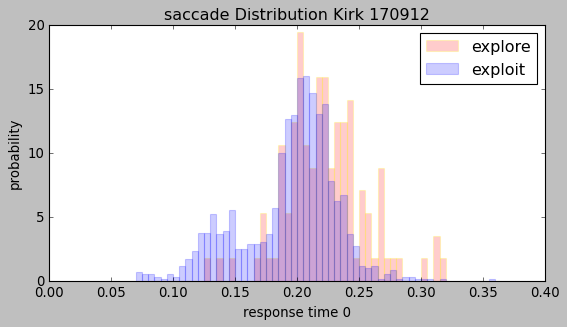

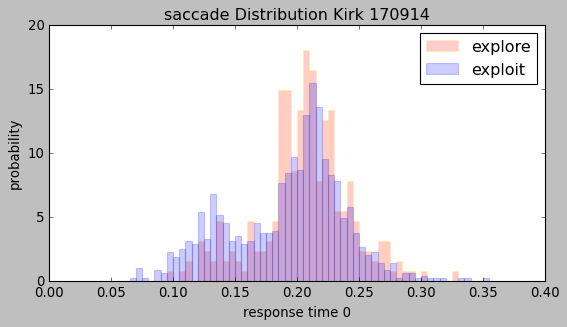

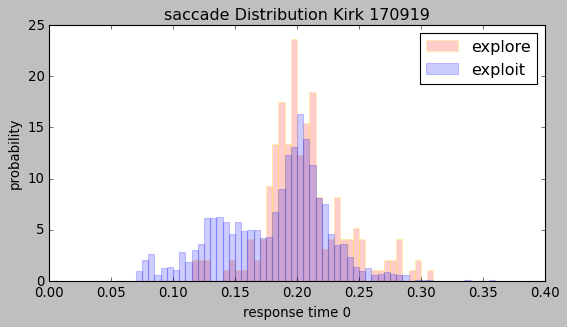

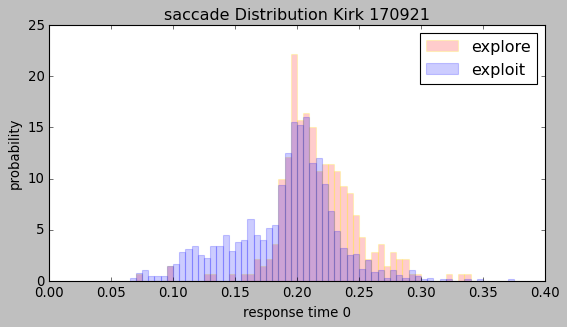

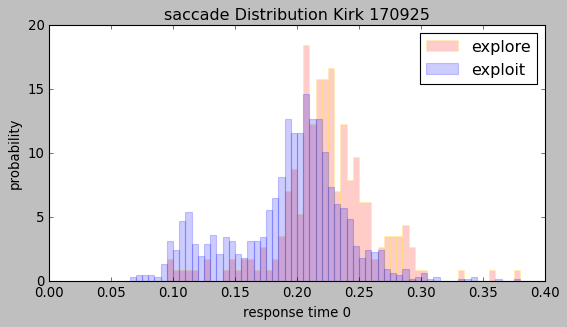

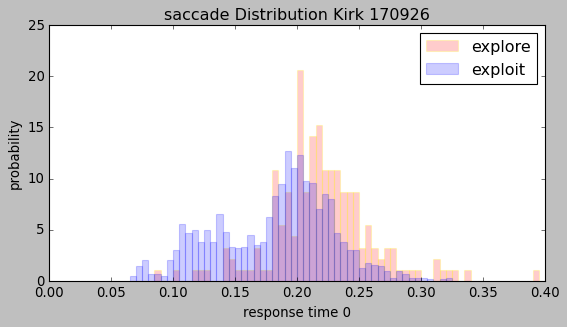

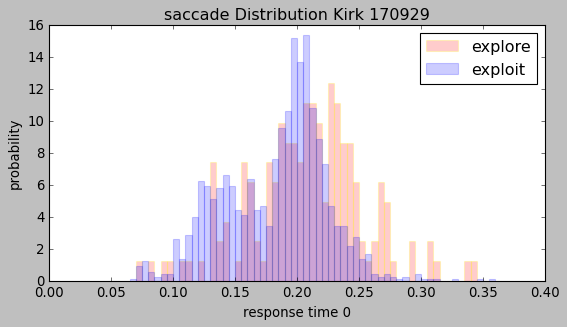

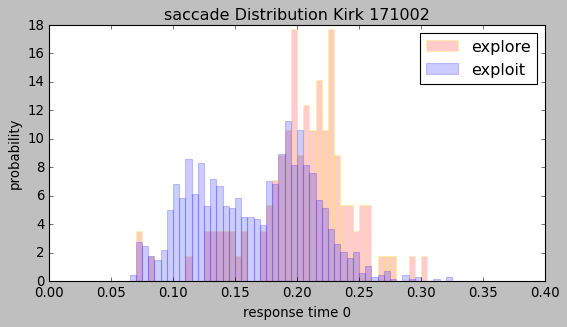

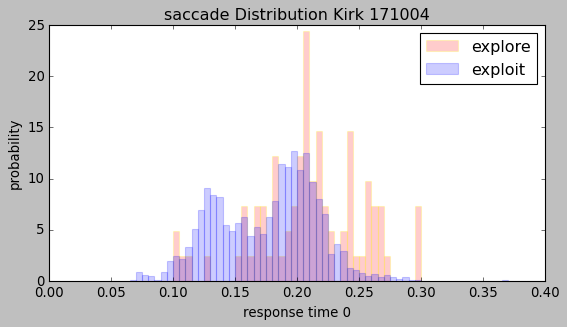

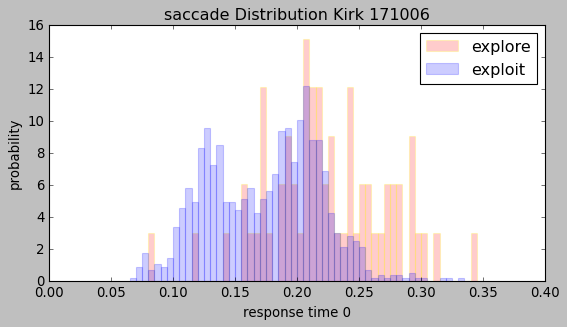

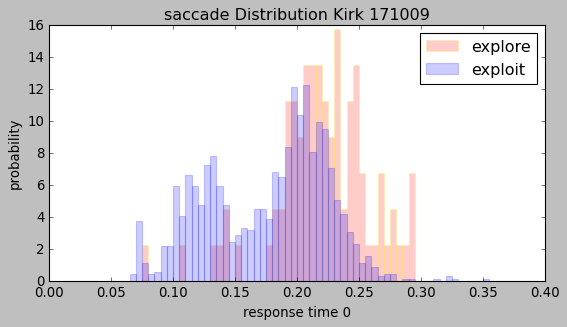

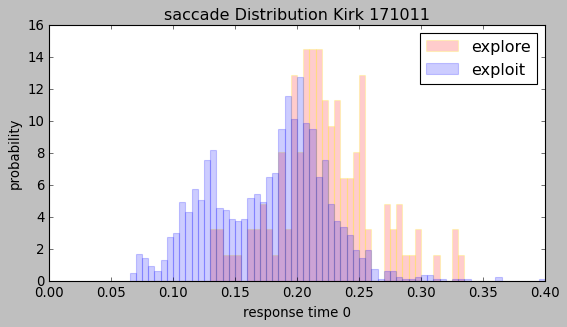

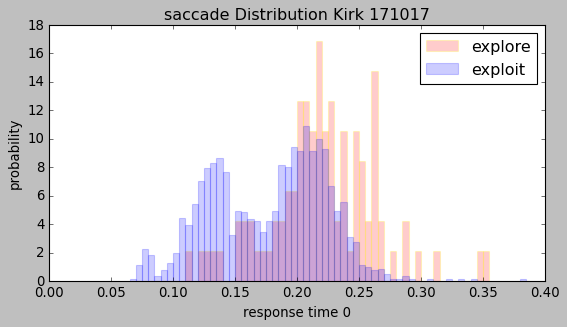

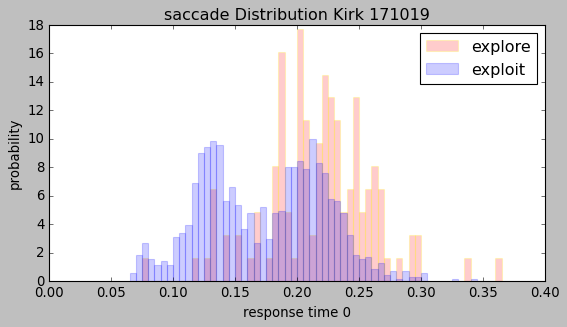

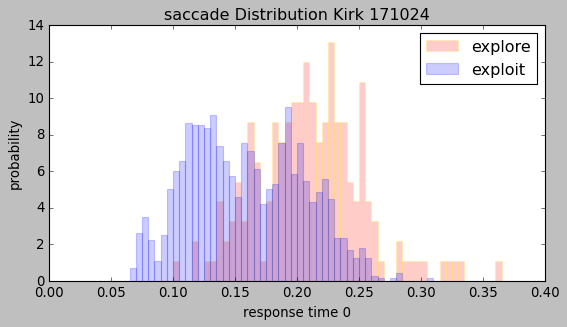

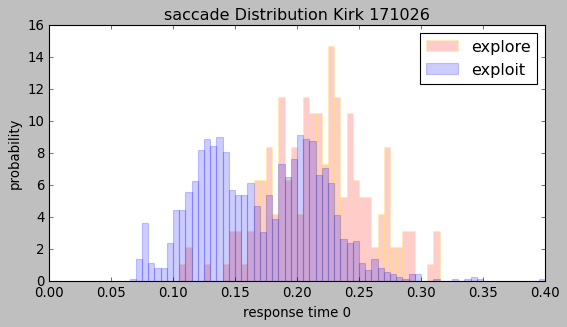

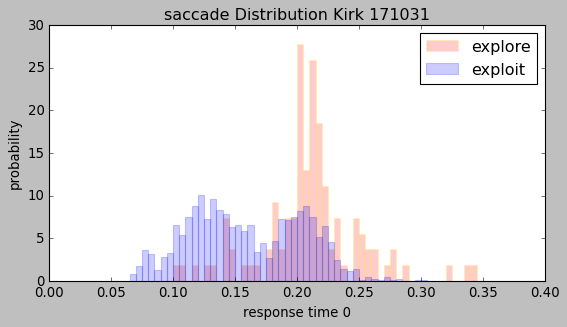

In [132]:
'''
df1 = pd.read_pickle('../Kirk.pkl')
df = df1[['trial','state', 'switch', 'stimTrial', 'rewarded','choice', 'correct','t1Rwd','t2Rwd','t3Rwd','animal_date','targOn','targAcq','rt']]
dates = df['animal_date'].unique()
'''
Runnning the same code but for all the sessions separately
Also saving the data in a dataframe of the probability distribution
'''

df = df[df['correct'] == 1]
for date in dates:
    df1 = df[(df['rt'] > 0.03 ) & (df['animal_date'] == date)]

    df1['explore'] = np.where((df1['state'] == 1), 1,0)
    df_stim = df1[(df1['explore'] ==1)].rt
    df_stim_not = df1[(df1['explore'] !=1)].rt
    plt.figure(figsize=(8,4))
    _ = plt.hist(df_stim,bins = np.arange(0,0.5,0.005), label='stimulated', alpha=0.2,color = 'r',  density = True,edgecolor='yellow')

    # plotting second histogram
    _ = plt.hist(df_stim_not,bins = np.arange(0,0.5,0.005), label='not-stimulated', alpha=0.2,color = 'b', density = True,edgecolor='blue')

    plt.xlim(0,0.4)
    plt.title(f'saccade Distribution Kirk {date}')

    # density_s = stats.gaussian_kde(df_stim)
    # density_ns = stats.gaussian_kde(df_stim_not)

    x = np.arange(0,0.4,0.001)
    # plt.plot(x,density_s(x),'r',x,density_ns(x),'b', linewidth = 2) # change the colors
    plt.legend(['explore', 'exploit'])#,'explore', 'exploit'])
    plt.xlabel('response time 0')
    plt.ylabel('probability')
    plt.savefig(f'../express_saccades/timon_bo_o/Kirk {date}.png')
'''

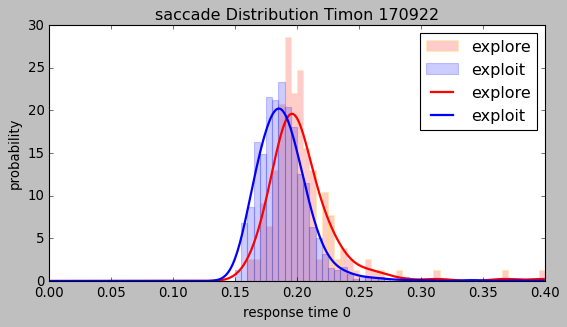

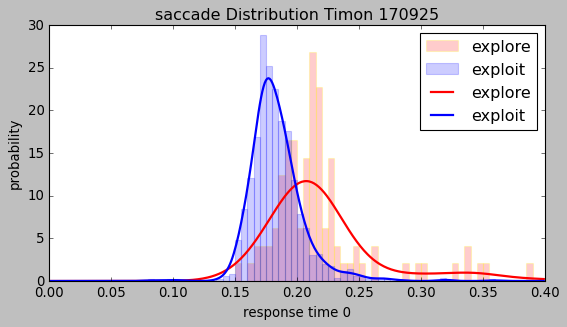

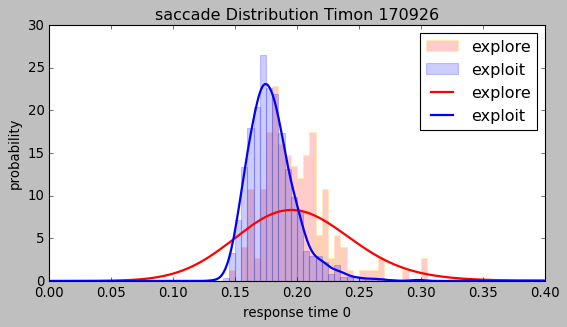

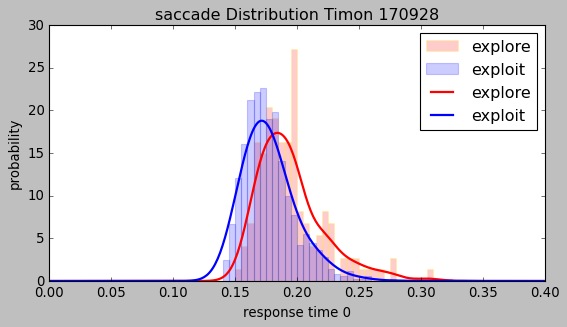

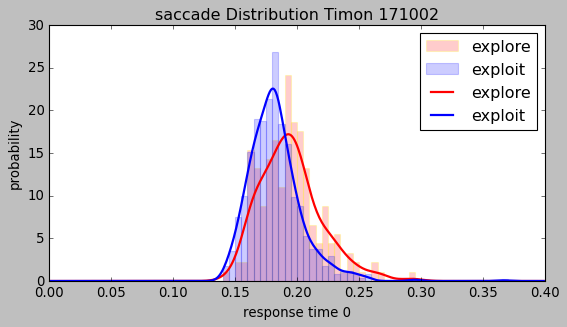

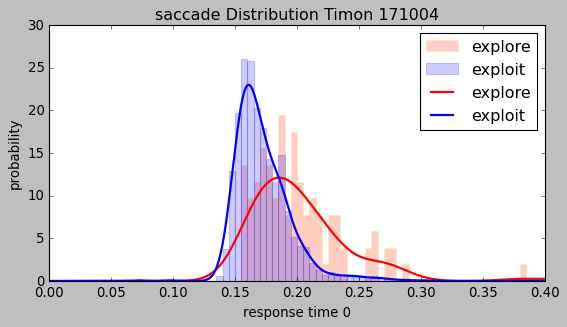

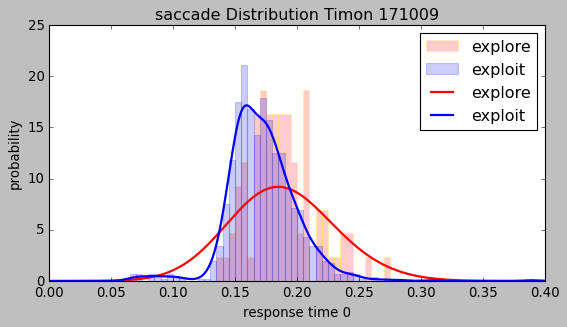

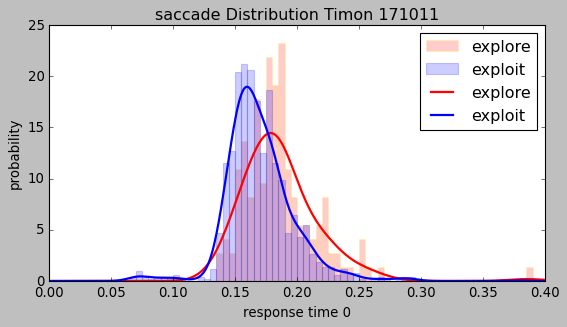

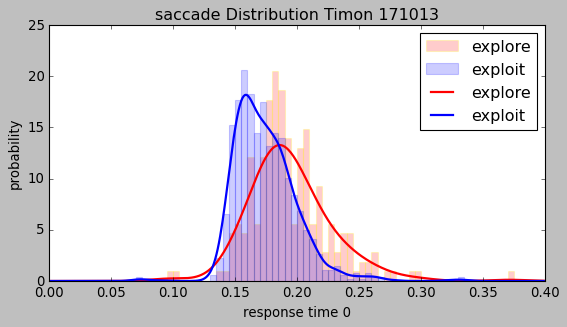

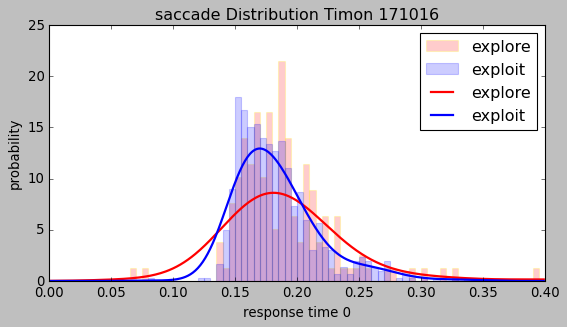

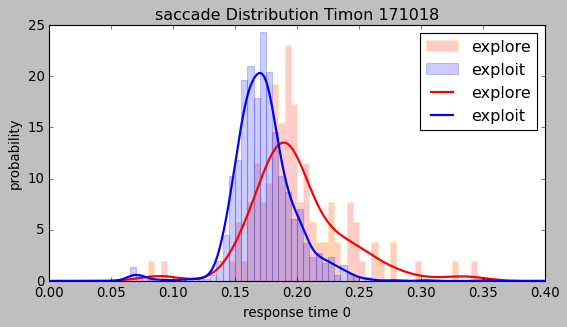

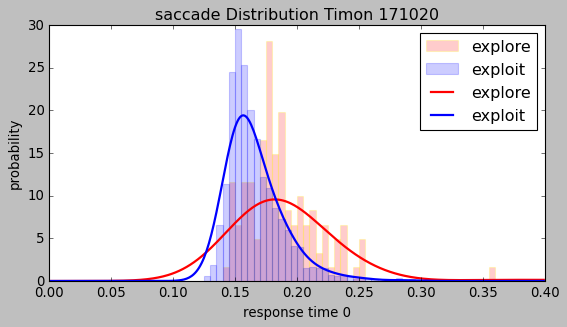

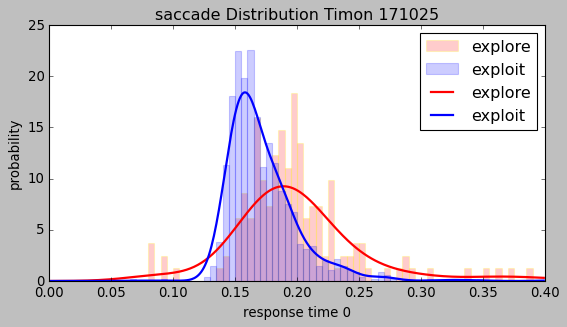

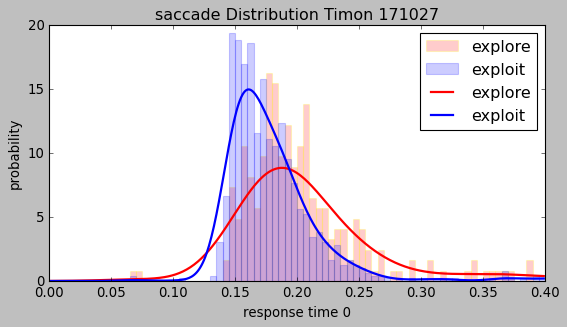

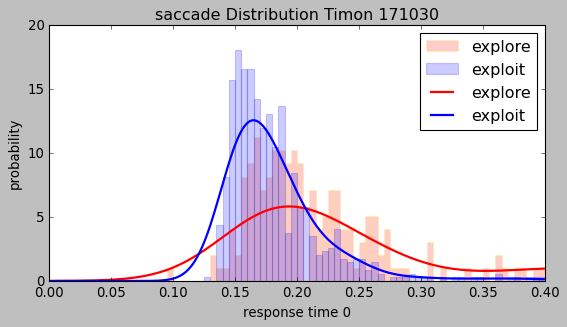

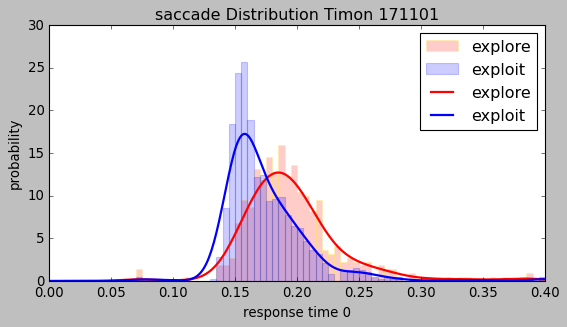

In [134]:
'''

df1 = pd.read_pickle('../Timon.pkl')
df = df1[['trial','state', 'switch', 'stimTrial', 'rewarded','choice', 'correct','t1Rwd','t2Rwd','t3Rwd','animal_date','targOn','targAcq','rt']]
dates = df['animal_date'].unique()
'''
Runnning the same code but for all the sessions separately
Also saving the data in a dataframe of the probability distribution
'''

df = df[df['correct'] == 1]
for date in dates:
    df1 = df[(df['rt'] > 0.03 ) & (df['animal_date'] == date)]

    df1['explore'] = np.where((df1['state'] == 1), 1,0)
    df_stim = df1[(df1['explore'] ==1)].rt
    df_stim_not = df1[(df1['explore'] !=1)].rt
    plt.figure(figsize=(8,4))
    _ = plt.hist(df_stim,bins = np.arange(0,0.5,0.005), label='stimulated', alpha=0.2,color = 'r',  density = True,edgecolor='yellow')

    # plotting second histogram
    _ = plt.hist(df_stim_not,bins = np.arange(0,0.5,0.005), label='not-stimulated', alpha=0.2,color = 'b', density = True,edgecolor='blue')

    plt.xlim(0,0.4)
    plt.title(f'saccade Distribution Timon {date}')

    density_s = stats.gaussian_kde(df_stim)
    density_ns = stats.gaussian_kde(df_stim_not)

    x = np.arange(0,0.4,0.001)
    plt.plot(x,density_s(x),'r',x,density_ns(x),'b', linewidth = 2) # change the colors
    plt.legend(['explore', 'exploit','explore', 'exploit'])
    plt.xlabel('response time 0')
    plt.ylabel('probability')
    # plt.savefig(f'../express_saccades/timon_bo_o/Timon {date}.png')

'''